# Chapter 3 Part 2:The shared corpus study
author: <span style="color:magenta">Poppy Riddle</span><br>
date: Mar 31, 2025
updated: July 31, 2025

## Data collection
- [x] create sample collection from Crossref from part 1
- [x] create shared corpus with works also found in OpenAlex matched on DOI
    - take DOI from Crossref sample df_collated2 export
    - send API call to OpenAlex for single work to select relevant elements or all and then refine down to elements needed for analysis
        - example API: https://api.openalex.org/works?filter=doi:10.7717/peerj.4375&select=doi,title,id,publication_year,language,abstract_inverted_index
    - reconstruct abstract from inverted 
        - [x] reconstruction code
- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
- [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc
    - [ ] visualize/diagram
- [x] quantify differences
    - [x] exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 
    - [x] clean Crossref data for jats tags - what about MathML? Use regex pattern from Part 1<br>
        #clean abstract<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: x.replace('\n','').lstrip())<br>
        #the following is from: https://github.com/ourresearch/openalex-walden/blob/main/notebooks/ingest/PDF.py<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: re.sub(r'<[^>]+>', '',x))<br>
    - [x] Levenshtein ratio for str values that can accept some variation without changing meaning: <br>
        I tried distance and seqratio, with and without stopwords removal. Both had unreliable results. <br>
        If this step is necessary to quantify some distance, then a more complex approach will be needed and more data cleaning: https://github.com/vatsal220/medium_articles/blob/main/levenshtein_distance/lev_dist.ipynb
- [x] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type.
- [x] subset analysis of title and abstract
    - [x] correct for false positives
    - [x] identify which error types occur: incorrect values, missing info, inconsistent values
    - [x] visualize: other pubs have used Sankey diagram to show change - other ways to do this? Or improve upon the Sankey approach?

## helpers:
### Python
- how to uninvert: https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index
- 


In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
import requests
import pickle
import json
from colorama import Fore,Back,Style
import time
import csv
import xmltodict #probably not needed here
from tqdm import tqdm

In [3]:
# get samples from part 1
#file = "data/part_1_sample.txt"
#df = pd.read_csv(file, sep='\t', encoding='utf-8', header=0)
#print(df.columns) # look at column names
##df.drop(['Unnamed: 0','level_0'], axis=1, inplace=True)
#df.head(1) # just look at first one

# load pickled data 

with open('Part_1_data/part_1_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df = pd.DataFrame(data)
print(len(df))
# unpack 'license' into 'license_version' and 'license_type'
df[['license_version', 'license_type']] = df['license'].apply(lambda x:pd.Series(x))
# handle empty values

# remove 'object' and 'license'
df.drop(columns=['object','license'], inplace=True)

# handle missing values
df.isnull().sum()
df.dtypes
df.replace({None:np.nan,'None':np.nan}, inplace=True)
df.info()
print(len(df))

# found duplicates! remove here and in the openalex data manually instead of rerunning data fetching from openalex
dupes = df[df.duplicated()]
print(dupes)
dupes.columns





10100
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10100 entries, ('journal-article', np.int64(0)) to ('book-chapter', np.int64(299))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              10100 non-null  object
 1   type             10100 non-null  object
 2   title            10100 non-null  object
 3   abstract         10100 non-null  object
 4   language         4966 non-null   object
 5   cited_by         10100 non-null  int64 
 6   url              10100 non-null  object
 7   license_version  5909 non-null   object
 8   license_type     5909 non-null   object
dtypes: int64(1), object(8)
memory usage: 814.8+ KB
10100
                                              DOI  ...                                       license_type
journal-article 1684  10.17239/jowr-2025.16.03.02  ...  https://creativecommons.org/licenses/by-nc-nd/...
                6992  10.22214/ijraset.2024.61751  ...          

Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type'], dtype='object')

In [3]:
# reconstruct abtract - from https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index


def reconstruct_abstract(abstract:dict)-> str:

    """
    This takes a dictionary of the inverted abstract
    and returns a string of the reconstructed abstract.

    Args:
    abstract should be in the form of a dictionary. 
    Example:
    abstract_inverted_index = {
    'Despite':[0],
    'growing':[1],
   'interest': [2],
    'in': [3],
    'Open': [4],
    'Access': [5],
    '...': [6]

    Returns:
    String 
    """

    # Create a list of (word, index) pairs
    word_index = []
    for k, v in abstract.items():
        for index in v:
            word_index.append([k, index])

    #print(word_index) # uncomment to see the sublists
    # Sort the list based on index
    word_index = sorted(word_index, key=lambda x: x[1]) # this sorts based on the second item in the sublist

    # Join the words with a space
    abstract = ' '.join([word for word, index in word_index])
    return abstract

In [4]:
# [x]: added requests.Session()<--
# get_openalex_data.py
import requests
import time
from functools import lru_cache

# Create a session object
session = requests.Session()

# send call to OpenAlex API
@lru_cache
def get_openalex_data(doi: str) -> dict:
    """
    Arg: takes a DOI as a string without the resolver.
    Return: A dictionary of values.

    Note: oa_abstract is reconstructed from the function reconstruct_abstract()
    """
    URL = f"https://api.openalex.org/works?filter=doi:{doi}&select=doi,title,id,type,type_crossref,language,abstract_inverted_index,cited_by_count,is_paratext,primary_location"

    try:
        result = session.get(URL)

        if result.status_code == 200:
            data = result.json()

            # Parse json data into each element:
            oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
            oa_title = data['results'][0]['title']
            oa_id = data['results'][0]['id']
            oa_type = data['results'][0]['type']
            oa_type_crossref = data['results'][0]['type_crossref']
            oa_language = data['results'][0]['language']
            oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
            oa_cited_by_count = data['results'][0]['cited_by_count']
            oa_is_paratext = data['results'][0]['is_paratext']
            oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
            oa_license = data['results'][0]['primary_location']['license']
            oa_version = data['results'][0]['primary_location']['version']

            # Reconstruct abstract
            oa_abstract = reconstruct_abstract(oa_abstract_inverted_index)

            return {
                'oa_doi': oa_doi,
                'oa_type': oa_type,
                'oa_type_crossref': oa_type_crossref,
                'oa_is_paratext': oa_is_paratext,
                'oa_title': oa_title,
                'oa_abstract': oa_abstract,
                'oa_language': oa_language,
                'oa_cited_by_count': oa_cited_by_count,
                'oa_primary_location_pdf_url': oa_primary_location_pdf_url,
                'oa_version': oa_version,
                'oa_license': oa_license,
                'oa_id': oa_id,
            }
        else:
            print(f"Error: Received status code {result.status_code} for DOI {doi}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed for DOI {doi}: {e}")
        return None
    finally:
        # Sleep so that you are below the 10 per second limit or 100k per day.
        time.sleep(0.11)

# Example usage
# doi = "10.1234/example"
# data = get_openalex_data(doi)
# print(data)


In [5]:
#WARNING: This will take nearly 2 hours to run the full 10,100!
from tqdm import tqdm

openalex_data = []

#REMOVE FOR FULL RUN!
#df = df.head(100)

for doi in tqdm(df['DOI'],colour="MAGENTA"):
    try:
        result = get_openalex_data(doi)
        openalex_data.append(result)
    except AttributeError:
        result = f"{doi}"

df_openalex = pd.DataFrame(openalex_data)

print(Fore.MAGENTA + df_openalex.columns)


# save out the goods
folder_to_be_saved = 'Part_2_data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.csv")

df_openalex.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.pkl")
df_openalex.to_pickle(pkl_to_be_saved)

df_openalex.head(2)

100%|██████████| 10100/10100 [59:47<00:00,  2.82it/s] 


Index(['oa_doi', 'oa_type', 'oa_type_crossref', 'oa_is_paratext', 'oa_title',
       'oa_abstract', 'oa_language', 'oa_cited_by_count', 'oa_primary_location_pdf_url',
       'oa_version', 'oa_license', 'oa_id'],
      dtype='object')


,oa_doi,oa_type,oa_type_crossref,oa_is_paratext,oa_title,oa_abstract,oa_language,oa_cited_by_count,oa_primary_location_pdf_url,oa_version,oa_license,oa_id
0,10.1521/soco.2021.39.5.543,article,journal-article,False,The Limits of Defaults: The Influence of Decis...,The stability of default effects to contextual...,en,4,None,None,None,https://openalex.org/W4206395497
1,10.1097/md.0000000000041851,article,journal-article,False,"Comparative analysis of demographic, clinical,...",The COVID-19 pandemic has brought a significan...,en,0,None,publishedVersion,cc-by-nc,https://openalex.org/W4408845899


# Analysis

- ✅ load and format data the same for easy comparison
- ✅  quantify differences
    - ✅  exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 


In [5]:
#make you a copy that does not have effects on the original
crossref_df = df.copy(deep=True)

#load you in the openalex data from the pickle
with open('Part_2_data/part_2_OA_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
openalex_df = pd.DataFrame(data)
print(len(openalex_df))

9990


In [6]:
print(Fore.LIGHTCYAN_EX + f"Crossref columns: \n{crossref_df.columns}")
print(Fore.LIGHTMAGENTA_EX + f"\n------\nOpenAlex columns: \n{openalex_df.columns}")

crossref_df.head(2).info()
print(len(crossref_df))


Crossref columns: 
Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type'], dtype='object')

------
OpenAlex columns: 
Index(['oa_doi', 'oa_type', 'oa_type_crossref', 'oa_is_paratext', 'oa_title', 'oa_abstract', 'oa_language',
       'oa_cited_by_count', 'oa_primary_location_pdf_url', 'oa_version', 'oa_license', 'oa_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2 entries, ('journal-article', np.int64(0)) to ('journal-article', np.int64(1))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              2 non-null      object
 1   type             2 non-null      object
 2   title            2 non-null      object
 3   abstract         2 non-null      object
 4   language         2 non-null      object
 5   cited_by         2 non-null      int64 
 6   url              2 non-null      object
 7   license_version  1 non-null  

In [7]:
crossref_df.iloc[1684]

DOI                                      10.17239/jowr-2025.16.03.02
type                                            journal-article:None
title              Linguistic and behavioral alignment in writing...
abstract           <jats:p>This article reports on a scoping revi...
language                                                         NaN
cited_by                                                           0
url                      https://www.jowr.org/jowr/article/view/1318
license_version                                          unspecified
license_type       https://creativecommons.org/licenses/by-nc-nd/...
Name: (journal-article, 1684), dtype: object

In [8]:
openalex_df.head(2).info()
len(openalex_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   oa_doi                       2 non-null      object
 1   oa_type                      2 non-null      object
 2   oa_type_crossref             2 non-null      object
 3   oa_is_paratext               2 non-null      bool  
 4   oa_title                     2 non-null      object
 5   oa_abstract                  2 non-null      object
 6   oa_language                  2 non-null      object
 7   oa_cited_by_count            2 non-null      int64 
 8   oa_primary_location_pdf_url  0 non-null      object
 9   oa_version                   1 non-null      object
 10  oa_license                   1 non-null      object
 11  oa_id                        2 non-null      object
dtypes: bool(1), int64(1), object(10)
memory usage: 310.0+ bytes


9990

In [9]:
# shared_corpus_df
shared_corpus_df = crossref_df.merge(openalex_df,left_on='DOI', right_on='oa_doi',how='right')
shared_corpus_df.drop_duplicates(keep='first', inplace=True)# use this throughout the notebook!
shared_corpus_df.columns
print(len(shared_corpus_df))

9988


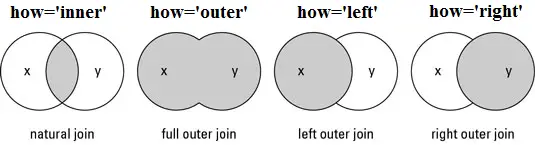<br>
source:https://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/

### overall changes
- [ ] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type -> 0 for missing, 1 for present
    - create table


In [11]:
# Nan for crossref_df, None for openalex_df
overall_change = crossref_df.merge(openalex_df,left_on='DOI', right_on='oa_doi',how='inner')
overall_change.drop_duplicates(keep='first', inplace=True)
print(len(overall_change))
overall_change = overall_change.replace({None:np.nan})
overall_change = overall_change.map(lambda x: 1 if pd.notna(x) else 0)

crossref_columns = ['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type']
openalex_columns = ['oa_doi', 'oa_type', 'oa_title', 'oa_abstract', 'oa_language', 'oa_cited_by_count', 'oa_primary_location_pdf_url', 'oa_version', 'oa_license']

crossref_overall_df = overall_change[crossref_columns]
openalex_overall_df = overall_change[openalex_columns]

crossref_overall_sums = pd.DataFrame(crossref_overall_df.sum())
openalex_overall_sums = pd.DataFrame(openalex_overall_df.sum())

crossref_overall_sums.reset_index(inplace=True)
crossref_overall_sums.rename(columns={'index': 'Element', 0: 'Crossref Sums'}, inplace=True)

openalex_overall_sums.reset_index(inplace=True)
openalex_overall_sums.rename(columns={'index':'OpenAlex', 0:'OA Sums'}, inplace=True)

overall_sums = pd.concat([crossref_overall_sums,openalex_overall_sums],axis=1 )
overall_sums = overall_sums.drop('OpenAlex', axis=1)

#save out
#overall_sums.to_excel("Part_2_tables/overall_sums.xlsx")
overall_sums


9988


,Element,Crossref Sums,OA Sums
0,DOI,9988,9988
1,type,9988,9988
2,title,9988,9985
3,abstract,9988,9988
4,language,4870,9965
5,cited_by,9988,9988
6,url,9988,5064
7,license_version,5852,6969
8,license_type,5852,4437


In [12]:
# add in table for count values for presence of each element
overall_sums_transposed = overall_sums.transpose()
#overall_sums_transposed.to_excel("Part_2_tables/overall_sums_transposed.xlsx")
overall_sums_transposed

,0,1,2,3,4,5,6,7,8
Element,DOI,type,title,abstract,language,cited_by,url,license_version,license_type
Crossref Sums,9988,9988,9988,9988,4870,9988,9988,5852,5852
OA Sums,9988,9988,9985,9988,9965,9988,5064,6969,4437


### DOI specific metadata
- [x] Matching DOIs between Crossref and OpenAlex
- [x] create table

In [13]:
# Compare Crossref df and oa df match on DOI
# new df with a boolean value if they share: doi, match_on_doi,...
# this will expand out for other boolean values

# match on df['doi'] and df_openalex['oa_doi']
match_on_doi_df = crossref_df[['DOI']].merge(openalex_df[['oa_doi']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_doi_df.drop_duplicates(keep='first', inplace=True)
match_on_doi_df['match_on_doi'] = match_on_doi_df['DOI'] == match_on_doi_df['oa_doi']

match_on_doi_df = match_on_doi_df.drop(['oa_doi'], axis=1)
true_count = len(match_on_doi_df[match_on_doi_df['match_on_doi']==True])

print(Fore.CYAN + f"percent matched from Crossref: {true_count/len(df)*100:.1f}%")
matched_on_doi_grouped = match_on_doi_df.groupby(['match_on_doi']).count()
print(Fore.LIGHTMAGENTA_EX + f"Matched on DOI: \n{matched_on_doi_grouped}")

#matched_on_doi_grouped.to_excel("Part_2_tables/matched_on_doi_grouped.xlsx")


percent matched from Crossref: 98.9%
Matched on DOI: 
               DOI
match_on_doi      
True          9988


## URL
- [x] Change in DOI URL from Crossref to OpenAlex, (0,1)
- [x] count of those that have https vs http (as an indicator of link rot)
- [x] count of HTTP status code on all URLs
- [x] count of those not working (such as 400)

In [14]:
#url and oa_primary_location_pdf_url

match_on_url_df = crossref_df[['DOI','url']].merge(openalex_df[['oa_doi','oa_primary_location_pdf_url']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_url_df.drop_duplicates(keep='first', inplace=True)
#fill in na with 'None'
match_on_url_df['oa_primary_location_pdf_url'] = match_on_url_df['oa_primary_location_pdf_url'].fillna('None')
#bool value on new column match_on_url
match_on_url_df['match_on_url'] = match_on_url_df['url'] == match_on_url_df['oa_primary_location_pdf_url']

match_on_url_df = match_on_url_df.drop(['oa_doi'], axis=1)
match_on_url_df_grouped = match_on_url_df.groupby(match_on_url_df['match_on_url'])['DOI'].count()
print(Fore.LIGHTCYAN_EX + f"Matched on URL: \n{match_on_url_df_grouped}")

#save out
#match_on_url_df_grouped.to_excel("Part_2_tables/match_on_url_df_grouped.xlsx")

#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_url_df.iloc[14,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_url_df.iloc[14,2]}")


# check for duplicate urls in either crossref or openalex - report this to Kyle
match_on_url_df['dupes'] = match_on_url_df['url'].duplicated(keep=False)
duplicates = match_on_url_df[match_on_url_df['dupes']]
print(f"\n------\nThere are this many duplicates: {len(duplicates)}")
print(f"That is {len(duplicates)/len(match_on_url_df)*100}% of {len(match_on_url_df)}")

#let's look at those that are false more closely
true_match_on_url_df = match_on_url_df[match_on_url_df['dupes']==True]
true_match_on_url_df = true_match_on_url_df[true_match_on_url_df['url'] != 'None']
print(Fore.LIGHTRED_EX + f"number of false matched on url: \n{len(true_match_on_url_df)}")
#true_match_on_url_df.to_excel("Part_2_tables/true_match_on_url_df.xlsx")
true_match_on_url_df

Matched on URL: 
match_on_url
False    9988
Name: DOI, dtype: int64
Crossref version: https://onlinelibrary.wiley.com/doi/10.1002/jocb.1534
OpenAlex version: None

------
There are this many duplicates: 2
That is 0.020024028834601523% of 9988
number of false matched on url: 
2


,DOI,url,oa_primary_location_pdf_url,match_on_url,dupes
9530,10.5327/1516-3180.142s1.12066,https://www.apm.org.br/wp-content/uploads/SPMJ...,None,False,True
9701,10.5327/1516-3180.142s1.12677,https://www.apm.org.br/wp-content/uploads/SPMJ...,None,False,True


In [15]:
# num with http vs https in url and in oa_primary_location_pdf_url
# clean up None in the openalex urls
match_on_url_df = match_on_url_df.replace({None:'None'})

#count 1 if there is http, otherwise 0 for https
match_on_url_df['cr_http_count'] = match_on_url_df['url'].apply(lambda x: 1 if x.startswith('http://') else 0)
match_on_url_df['oa_http_count'] = match_on_url_df['oa_primary_location_pdf_url'].apply(lambda x: 1 if x.startswith('http://') else 0)

match_on_url_http_count = match_on_url_df[['cr_http_count','oa_http_count']]
match_on_url_http_count = pd.DataFrame(match_on_url_http_count.sum(),columns=['Counts'])
#match_on_url_http_count.to_excel("Part_2_tables/match_on_url_http_count.xlsx")
match_on_url_http_count


,Counts
cr_http_count,958
oa_http_count,380


In [16]:
# http status codes
# Previously I did the Crossref ones. they are stored in a pickle here:
# and load pickle if you need
with open('Part_1_data/df_data_url.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
crossref_data_url = pd.DataFrame(data)
len(crossref_data_url)
crossref_data_url.reset_index(inplace=True)
crossref_data_url.drop(columns=['level_0','level_1'], inplace=True)
crossref_data_url.drop_duplicates(keep='first', inplace=True)
crossref_data_url

,DOI,url,type,status_code
0,10.1521/soco.2021.39.5.543,https://guilfordjournals.com/doi/10.1521/soco....,journal-article:None,403
1,10.1097/md.0000000000041851,https://journals.lww.com/10.1097/MD.0000000000...,journal-article:None,403
2,10.32996/jmcie.2021.2.2.10,https://www.al-kindipublisher.com/index.php/jm...,journal-article:None,200
3,10.12957/cdf.2025.89476,https://www.e-publicacoes.uerj.br/cdf/article/...,journal-article:None,200
4,10.51845/36.4.15,https://www.nas.org/academic-questions/36/4/ge...,journal-article:None,200
...,...,...,...,...
10095,10.1093/hesc/9780198866657.003.0038,https://www.oxfordsciencetrove.com/view/10.109...,book-chapter:None,403
10096,10.3735/9781935306627.book-part-182,https://library.schlagergroup.com/chapter/9781...,book-chapter:None,200
10097,10.1093/oso/9780197619995.003.0005,https://academic.oup.com/book/38898/chapter/33...,book-chapter:None,403
10098,10.1007/978-3-658-42221-9_10,https://link.springer.com/10.1007/978-3-658-42...,book-chapter:None,200


In [17]:
from check_status_code import check_status_code,check_urls

tqdm.pandas(colour='cyan')

#covert the column 'oa_primary_location_pdf_url' to a list
urls = openalex_df['oa_primary_location_pdf_url'].tolist()

#check status codes with multithreading function - takes a list
print(Fore.LIGHTMAGENTA_EX + f"hang on...this can take a while for the length of this list: {len(urls)} list...\n")
status_codes = tqdm(check_urls(urls),colour='cyan')

openalex_data_url = openalex_df[['oa_doi', 'oa_primary_location_pdf_url', ]].copy()
openalex_data_url['openalex_status_code'] = status_codes


#openalex_data_url = openalex_df[['oa_doi','oa_primary_location_pdf_url']]
#openalex_data_url['openalex_status_code'] = openalex_data_url['oa_primary_location_pdf_url'].progress_apply(lambda x: check_status_code(x) if pd.notna(x) else "Access Failed")

# save out the openalex_data_url to a pickle for loading later
openalex_data_url.to_pickle('Part_2_data/openalex_data_url.pkl')



hang on...this can take a while for the length of this list: 9990 list...



100%|██████████| 9990/9990 [00:00<00:00, 2659711.63it/s]


In [485]:
print(openalex_data_url.iloc[15,1])
openalex_data_url

Attempt failed


,oa_doi,openalex_status_code,crossref_status_code
0,10.1521/soco.2021.39.5.543,Attempt failed,403
1,10.1097/md.0000000000041851,Attempt failed,403
2,10.32996/jmcie.2021.2.2.10,Attempt failed,200
3,10.12957/cdf.2025.89476,Attempt failed,200
4,10.51845/36.4.15,Attempt failed,200
...,...,...,...
9989,10.7591/cornell/9781501766985.003.0002,Attempt failed,403
9990,10.1093/hesc/9780198866657.003.0038,200,403
9991,10.3735/9781935306627.book-part-182,200,200
9992,10.1093/oso/9780197619995.003.0005,200,403


In [17]:
# load saaved openalex_data_url from pickle
with open('Part_2_data/openalex_data_url.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)
openalex_data_url = pd.DataFrame(data)

# need to combine this with the imported ones from crossref url to match on DOI
openalex_data_url = openalex_data_url.merge(crossref_data_url, left_on='oa_doi', right_on='DOI', how='inner')
openalex_data_url.drop_duplicates(keep='first', inplace=True)
openalex_data_url = openalex_data_url[['oa_doi', 'openalex_status_code','status_code']]

openalex_data_url = openalex_data_url.rename(columns={'status_code':'crossref_status_code'})
openalex_data_url


openalex_count = pd.DataFrame(openalex_data_url.groupby(openalex_data_url['openalex_status_code'])['oa_doi'].count())
crossref_count = pd.DataFrame(openalex_data_url.groupby(openalex_data_url['crossref_status_code'])['oa_doi'].count())

openalex_count = openalex_count.rename_axis('Status code').rename(columns={'oa_doi':'openalex count'})
crossref_count = crossref_count.rename_axis('Status code').rename(columns={'oa_doi':'crossref count'})

total_counts = pd.concat([openalex_count, crossref_count], axis=1)
total_counts = total_counts.sort_index(ascending=True)
total_counts['oa_percent'] = total_counts['openalex count'].apply(lambda x: f"{x/len(openalex_data_url)*100:.2f}")
total_counts['cr_percent'] = total_counts['crossref count'].apply(lambda x: f"{x/len(crossref_data_url)*100:.2f}")
#save out
#total_counts.to_excel("Part_2_tables/total_counts.xlsx")

total_counts


,openalex count,crossref count,oa_percent,cr_percent
Status code,,,,
200,3194.0,6227.0,31.98,61.67
202,14.0,NaN,0.14,nan
400,2.0,4.0,0.02,0.04
401,NaN,1.0,nan,0.01
403,1478.0,2879.0,14.80,28.51
404,104.0,74.0,1.04,0.73
405,1.0,5.0,0.01,0.05
406,NaN,82.0,nan,0.81
409,2.0,NaN,0.02,nan


### publication type
- [x] count of each type
- [x] change from Crossref to Openalex, 0,1?
- [ ] % distribution 
- [ ] maybe a good place for a sankey diagram showing changes

In [18]:
# compare exact match for values -> bool
# check for type - make this into a sankey diagram
# match on crossref_df[['DOI',type]] and openalex_df[['oa_doi','oa_type', 'oa_type_crossref']]
match_on_type_df = crossref_df[['DOI','type']].merge(openalex_df[['oa_doi','oa_type', 'oa_type_crossref']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_type_df.drop_duplicates(keep='first', inplace=True)
#refine type from crossref to rstrip ':None'
match_on_type_df['type'] = match_on_type_df['type'].apply(lambda x: x.replace(':None',''))
match_on_type_df['match_on_type'] = match_on_type_df['type'] == match_on_type_df['oa_type_crossref']

match_on_type_df = match_on_type_df.drop(['oa_doi'], axis=1)
match_on_type_df_grouped = match_on_type_df.groupby(match_on_type_df['match_on_type'])['DOI'].count()
print(Fore.GREEN + f"Matched on type: \n{match_on_type_df_grouped}")

# save out
#match_on_type_df_grouped.to_excel("Part_2_tables/match_on_type_df_grouped.xlsx")
match_on_type_df[match_on_type_df['match_on_type']==False]

Matched on type: 
match_on_type
False       7
True     9981
Name: DOI, dtype: int64


,DOI,type,oa_type,oa_type_crossref,match_on_type
1187,10.1002/for.2701,journal-article,paratext,other,False
3464,10.1111/rec3.12328,journal-article,paratext,other,False
3477,10.1002/jrs.6396,journal-article,paratext,other,False
4483,10.1111/ffe.14338,journal-article,paratext,other,False
5185,10.1142/s0219887824501810,journal-article,preprint,posted-content,False
6090,10.1111/medu.15433,journal-article,paratext,other,False
6973,10.1002/ppp.2236,journal-article,paratext,other,False


In [19]:
type_false_grouped = match_on_type_df[match_on_type_df['match_on_type']==False]
print(type_false_grouped)
#type_false_grouped.to_excel("Part_2_tables/type_false_grouped_manual_inspection.xlsx")
print(f"length of type_false_grouped: \n{len(type_false_grouped)}")
type_false_grouped = type_false_grouped.groupby(['type']).count()
type_false_grouped

                            DOI             type   oa_type oa_type_crossref  match_on_type
1187           10.1002/for.2701  journal-article  paratext            other          False
3464         10.1111/rec3.12328  journal-article  paratext            other          False
3477           10.1002/jrs.6396  journal-article  paratext            other          False
4483          10.1111/ffe.14338  journal-article  paratext            other          False
5185  10.1142/s0219887824501810  journal-article  preprint   posted-content          False
6090         10.1111/medu.15433  journal-article  paratext            other          False
6973           10.1002/ppp.2236  journal-article  paratext            other          False
length of type_false_grouped: 
7


,DOI,oa_type,oa_type_crossref,match_on_type
type,,,,
journal-article,7,7,7,7


### title
- [x] change between Crossref and OpenAlex 0,1?
<br>If False, then<br>
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

In [490]:
# re.sub('\s{2,}', ' ', text)
import re
# match on title
match_on_title_df = crossref_df[['DOI', 'title']].merge(openalex_df[['oa_doi','oa_title']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_title_df.drop_duplicates(keep='first', inplace=True)
# text cleaning for extra spaces
match_on_title_df[['title','oa_title']] = match_on_title_df[['title', 'oa_title']].map(lambda x: re.sub(r'\s{2,}', ' ', str(x)))

# If you want to strip leading and trailing spaces as well
match_on_title_df = match_on_title_df.map(lambda x: x.strip() if pd.notna(x) else x)

# remove non-break characters and others from Latin-1 supplement or General Punc
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u00A0', '\u0020'))
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u000D', '\u0020'))
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u2010', '\u0020'))

# remove <i> formatting
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace(r'<i>', '').replace(r'</i>',''))

match_on_title_df['match_on_title'] = match_on_title_df['title'] == match_on_title_df['oa_title']
match_on_title_df = match_on_title_df.drop(['oa_doi'], axis=1)
match_on_title_df_grouped = match_on_title_df.groupby(match_on_title_df['match_on_title'])['DOI'].count()
print(match_on_title_df_grouped)

#save out
match_on_title_df_grouped.to_excel("Part_2_tables/match_on_title_df_grouped.xlsx")

# let's manualy check those false values..
false_values = match_on_title_df[match_on_title_df['match_on_title']==False].index
print(Fore.LIGHTYELLOW_EX + f"\n----\nfalse value index: {false_values[1]}")
print(match_on_title_df.iloc[false_values[1],1:3])
#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[false_values[1],1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[false_values[1],2]}")




match_on_title
False     213
True     9775
Name: DOI, dtype: int64

----
false value index: 31
title       Investigation of laser plasma instabilities dr...
oa_title    Investigation of laser plasma instabilities dr...
Name: 31, dtype: object
Crossref version: Investigation of laser plasma instabilities driven by 527 nm laser pulses relevant for direct drive inertial confinement fusion
OpenAlex version: Investigation of laser plasma instabilities driven by 527 nm laser pulses relevant for direct drive inertial confinement fusion


In [491]:
# all False in a separate df and analyse manually
false_match_on_title = match_on_title_df[match_on_title_df['match_on_title']==False]
# then add these back into match_on_title_df to replace values in 'match_on_title'
match_on_title_df.columns
# export in excel and manually work on them

#Don't uncomment unless you want to overwrite the manual review!!!
#false_match_on_title.to_excel("Part_2_data/false_match_on_title_2.xlsx")#changed name just to be safe.
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[116,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[116,2]}")



Crossref version: Face Recognition Algorithm Based On Convolutional Neural Network
OpenAlex version: Face Recognition Algorithm Based On Convolutional Neural Network


### abstract
- [x] change between Crossref and OpenAlex?<br>
If failed then...
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

In [492]:
# match on abstract - use same process as title?
# re.sub('\s{2,}', ' ', text)

import unicodedata

def remove_general_punc(s: str) -> str:
    """
    Removes characters from the Unicode General Punctuation block.
    Purpose: remove thin space characters from text by specifying codepoints
    """
    general_punctuation = set()
    for i in range(0x2000, 0x2070):
        general_punctuation.add(chr(i))

    return ''.join([char for char in s if char not in general_punctuation])

# match on abstract
match_on_abstract_df = crossref_df[['DOI', 'abstract']].merge(openalex_df[['oa_doi','oa_abstract']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_abstract_df.drop_duplicates(keep='first', inplace=True)
# text cleaning for all JATS tags
#source: https://github.com/ourresearch/openalex-walden/blob/main/libraries/dlt_utils/openalex/dlt/transform.py
match_on_abstract_df[['abstract','oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: re.sub(r"\n|\t|<jats:[^>]*?>|</jats:[^>]*?>|<p>|</p>", ' ', str(x)))
# text cleaning for extra spaces
match_on_abstract_df[['abstract','oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: re.sub(r'\s{2,}', ' ', str(x)))
# if you want to strip leading and trailing spaces as well
match_on_abstract_df = match_on_abstract_df.map(lambda x: x.strip() if pd.notna(x) else x)
# remove all thin space
match_on_abstract_df[['abstract', 'oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: remove_general_punc(x))

match_on_abstract_df['match_on_abstract'] = match_on_abstract_df['abstract'] == match_on_abstract_df['oa_abstract']
match_on_abstract_df = match_on_abstract_df.drop(['oa_doi'], axis=1)
match_on_abstract_df_grouped = match_on_abstract_df.groupby(match_on_abstract_df['match_on_abstract'])['DOI'].count()
print(match_on_abstract_df_grouped)

# save out
match_on_abstract_df_grouped.to_excel("Part_2_tables/match_on_abstract_df_grouped.xlsx")

# num_match
num_match = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==True]["DOI"].count()
print(Fore.LIGHTYELLOW_EX + f"number of those that match: {num_match} out of {len(match_on_abstract_df)}")


match_on_abstract
False    2021
True     7967
Name: DOI, dtype: int64
number of those that match: 7967 out of 9988


In [493]:
#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[0,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[0,2]}")

#individually correct the false positives
# let's manualy check those false values..
false_values = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==False].index
print(Fore.LIGHTYELLOW_EX + f"\n----\nfalse value index: {false_values[0]} out of {len(false_values)}")

#create a new df with just those with False values
false_match_on_abstract = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==False]

#save out for manual check
# DON'T UNCOMMENT OTHERWISE IT WILL OVERWRITE THE MANUAL CORRECTIONS
#false_match_on_abstract.to_excel("Part_2_data/false_match_on_abstract_2.xlsx")#CHANGED NAME JUST TO BE SURE

#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[false_values[0],1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[false_values[0],2]}")

Crossref version: The stability of default effects to contextual features is critical to their use in policy. In this paper, decision time was investigated as a contextual factor that may pose limits on the efficacy of defaults. Consistent with the hypothesis that time constraints may increase reliance on contextual cues, four experiments, including a preregistered one of a nationally representative sample, and a meta-analysis that included four additional pilot experiments, indicated that short decision times increased the advantage of action defaults (i.e., the default option automatically endorsed the desired behavior) and that the default advantage was trivial or nonexistent when decision times were longer. These effects replicated for naturalistic as well as externally induced decision times and were present even when participants were unaware that time was limited. This research has critical implications for psychological science and allied disciplines concerned with policy in th

## cited by count
- [ ] std dev of differences between two samples
- [ ] n with change
- [ ] % affected
- [ ] visualize to see if one database favors more than the other

In [494]:
# cited_by and oa_cited_by_count 

match_on_cited_df = crossref_df[['DOI','cited_by']].merge(openalex_df[['oa_doi','oa_cited_by_count']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_cited_df.drop_duplicates(keep='first', inplace=True)
match_on_cited_df['match_on_cited'] = match_on_cited_df['cited_by'] == match_on_cited_df['oa_cited_by_count']

match_on_cited_df = match_on_cited_df.drop(['oa_doi'], axis=1)
match_on_cited_df_grouped = pd.DataFrame(match_on_cited_df.groupby(match_on_cited_df['match_on_cited'])['DOI'].count())
match_on_cited_df_grouped['percent'] = match_on_cited_df_grouped['DOI'].apply(lambda x:f"{x/len(match_on_cited_df)*100:.2f}")
print(Fore.LIGHTMAGENTA_EX + f"Matched on cited_by: \n{match_on_cited_df_grouped}")

# save out
match_on_cited_df_grouped.to_excel("Part_2_tables/match_on_cited_df_grouped.xlsx")

Matched on cited_by: 
                 DOI percent
match_on_cited              
False           4111   41.16
True            5877   58.84


In [495]:
print(Fore.LIGHTBLUE_EX + f"OpenAlex: \n{match_on_cited_df['cited_by'].agg(['mean','median','max','min'])}")
print(Fore.LIGHTGREEN_EX + f"Crossref:\n{match_on_cited_df['oa_cited_by_count'].agg(['mean','median','max','min'])}")

cr_cited_by_df = pd.DataFrame(match_on_cited_df['cited_by'].agg(['mean','median','max','min']))
oa_cited_by_df = pd.DataFrame(match_on_cited_df['oa_cited_by_count'].agg(['mean','median','max','min']))

cited_by_df = cr_cited_by_df.join(oa_cited_by_df, how='outer',lsuffix="crossref",rsuffix='openalex')
cited_by_df.to_excel("Part_2_tables/cited_by_min_max_med.xlsx")
cited_by_df


OpenAlex: 
mean        4.071886
median      0.000000
max       505.000000
min         0.000000
Name: cited_by, dtype: float64
Crossref:
mean        5.522327
median      1.000000
max       640.000000
min         0.000000
Name: oa_cited_by_count, dtype: float64


,cited_by,oa_cited_by_count
max,505.000000,640.000000
mean,4.071886,5.522327
median,0.000000,1.000000
min,0.000000,0.000000


### license
- [x] change between Crossref and OpenAlex?
- [ ] count of types for each
- [ ] count of those with licenses vs without
- [ ] % of those with 
- [ ] count of common or proprietary licenses
- [ ] visualization of distribution of license types

In [496]:
#license_type and oa_license

match_on_license_type_df = crossref_df[['DOI','license_type']].merge(openalex_df[['oa_doi','oa_license']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_license_type_df.drop_duplicates(keep='first', inplace=True)
#cleaning: crossref - replace  http://creativecommons.org/licenses/ and  https://creativecommons.org/licenses/ with 'cc-'
# remove trailing /
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('http://creativecommons.org/licenses/', 'cc-')
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('https://creativecommons.org/licenses/', 'cc-')

# replace misspelled cc-bv and convert all to lowercase
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('cc-bv', 'cc-by').str.lower()
#.str.replace('\d+', '') - remove digits from license_type
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('7','')

#removes all proprietary license types
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].apply(lambda x: re.sub(r'/.*','',str(x)) if pd.notna(x) else x)
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('http:', 'None')
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('https:', 'None')
#replaces np.nan with 'None' 
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].fillna(value='None')
match_on_license_type_df['oa_license'] = match_on_license_type_df['oa_license'].apply(lambda x: str(x))


match_on_license_type_df['match_on_license_type'] = match_on_license_type_df['license_type'] == match_on_license_type_df['oa_license']

match_on_license_type_df = match_on_license_type_df.drop(['oa_doi'], axis=1)
match_on_license_type_df_grouped = pd.DataFrame(match_on_license_type_df.groupby(match_on_license_type_df['match_on_license_type'])['DOI'].count())
# add percent column
match_on_license_type_df_grouped['percent'] = match_on_license_type_df_grouped['DOI'].apply(lambda x: f"{x/len(match_on_license_type_df)*100:.2f}")
print(Fore.LIGHTCYAN_EX + f"Matched on license type: \n{match_on_license_type_df_grouped}")
#save out
match_on_license_type_df_grouped.to_excel("Part_2_tables/match_on_license_type_df_grouped.xlsx")

#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_license_type_df.iloc[19,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_license_type_df.iloc[19,2]}")

# for manual inspection of false ones
match_on_license_type_df.columns
false_match_on_license_type = match_on_license_type_df[match_on_license_type_df['match_on_license_type']==False]
false_match_on_license_type.to_excel("Part_2_tables/false_match_on_license_type.xlsx")
false_match_on_license_type



Matched on license type: 
                        DOI percent
match_on_license_type              
False                  2545   25.48
True                   7443   74.52
Crossref version: cc-by-sa
OpenAlex version: None


,DOI,license_type,oa_license,match_on_license_type
2,10.32996/jmcie.2021.2.2.10,cc-by,None,False
9,10.16899/jcm.1241809,None,cc-by-nc-nd,False
10,10.62810/jss.v6i3.106,cc-by-nc,None,False
16,10.55529/jpdmhd.46.33.45,None,cc-by,False
17,10.54097/hset.v28i.4050,cc-by-nc,None,False
...,...,...,...,...
9890,10.36906/ksp-2023/46,cc-by,None,False
9905,10.58830/ozgur.pub582.c2394,None,cc-by-nc,False
9915,10.18778/8220-556-5.07,None,cc-by-nc-nd,False
9954,10.3233/atde250083,cc-by-nc,None,False


In [497]:
# do a groupby on 'license_type' then by 'oa_license' to see how many counts of these line up
#which are most frequently not aligned?
false_match_on_license_type_grouped = false_match_on_license_type.groupby(['license_type','oa_license'])[['DOI']].count()
false_match_on_license_type_grouped.to_excel("Part_2_tables/false_match_on_license_type_grouped.xlsx")
false_match_on_license_type_grouped

DOI
license_type oa_license                
None         cc-by                  445
             cc-by-nc               138
             cc-by-nc-nd            119
             cc-by-nc-sa            103
             cc-by-nd                10
             cc-by-sa                90
             mit                      1
             other-oa                27
             public-domain            8
             publisher-specific-oa   39
cc-          cc-by                    1
             cc-by-nc                 1
cc-authors   None                     1
cc-by        None                   880
             cc-by-nc                20
             cc-by-nc-nd             31
             cc-by-nc-sa              7
             cc-by-nd                 1
             other-oa                 2
cc-by-nc     None                   139
             cc-by                   11
             cc-by-nc-nd              7
             cc-by-nc-sa              3
             cc-by-sa                 2
             publisher-specific-oa    1
cc-by-nc-nd  None                   128
             cc-by                   16
             cc-by-nc                 5
             cc-by-nc-sa              5
             publisher-specific-oa    1
cc-by-nc-sa  None                    89
             cc-by                    4
             cc-by-nc                 4
             cc-by-nc-nd              7
             cc-by-nd                 1
             cc-by-sa                 8
cc-by-nd     None                     9
             cc-by                    1
             cc-by-nc-nd              1
cc-by-sa     None                   175
             cc-by                    1
             cc-by-nc-nd              2
cc-cc        cc-by-nc-nd              1

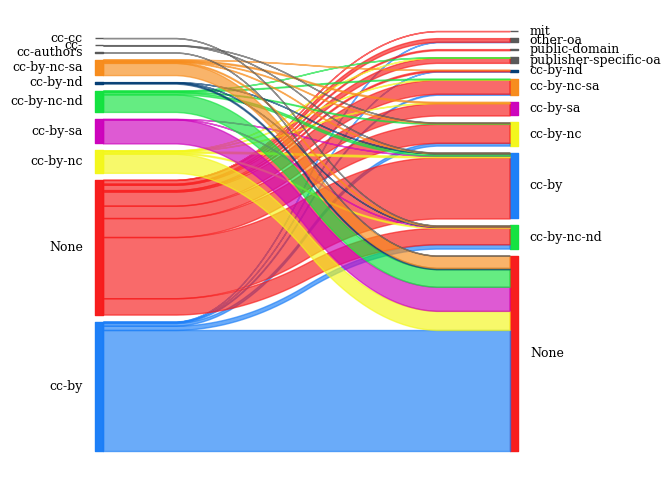

In [498]:
# sankey diagram with pySankey
from pySankey.sankey import sankey
colors = {
    'None':'#f71b1b',
    'cc-by':'#1b7ef7',
    'cc-by-nc':'#f3f71b',
    'cc-by-nc-nd':'#12e23f',
    'cc-by-nc-sa':'#f78c1b',
    'cc-by-nd':'#043e74',
    'cc-by-sa':'#cd02bc',
    'mit':'#585858',
    'nan':'#87541b',
    'other-oa':'#585858',
    'public-domain':'#585858',
    'publisher-specific-oa':'#585858',
    'cc-cc':'#585858',
    'cc-authors':'#585858',
    'cc-':'#585858'
}

sankey(left=false_match_on_license_type['license_type'],
        right=false_match_on_license_type['oa_license'],
        aspect=20,
        colorDict=colors,
        fontsize=9)

### Crossref's vor
Crossref's 'vor' license version is equivalent to the published version. <br>
See reference here: https://www.crossref.org/documentation/principles-practices/best-practices/versioning/

In [499]:
# license version check

match_on_license_version_df = crossref_df[['DOI','license_version']].merge(openalex_df[['oa_doi','oa_version']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_license_version_df.drop_duplicates(keep='first', inplace=True)
# change vor to published version
match_on_license_version_df['license_version'] = match_on_license_version_df['license_version'].apply(lambda x: 'publishedVersion' if x=='vor' else x)
#change NaN to 'None'
match_on_license_version_df['license_version'] = match_on_license_version_df['license_version'].fillna(value='None')

# convert NoneType to string in 'oa_version'
match_on_license_version_df['oa_version'] = match_on_license_version_df['oa_version'].apply(lambda x: str(x))

#create bool value column
match_on_license_version_df['match_on_license_version'] = match_on_license_version_df['license_version'] == match_on_license_version_df['oa_version']

match_on_license_version_df = match_on_license_version_df.drop(['oa_doi'], axis=1)
match_on_license_version_df_grouped = pd.DataFrame(match_on_license_version_df.groupby(match_on_license_version_df['match_on_license_version'])['DOI'].count())
# add in percent
match_on_license_version_df_grouped['percent'] = match_on_license_version_df_grouped['DOI'].apply(lambda x: f"{x/len(match_on_license_version_df)*100:.2f}")
print(Fore.LIGHTMAGENTA_EX + f"Matched on license version: \n{match_on_license_version_df_grouped}")

#save out
match_on_license_version_df_grouped.to_excel("Part_2_tables/match_on_license_version_df_grouped.xlsx")
#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_license_version_df.iloc[19,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_license_version_df.iloc[19,2]}")

match_on_license_version_df


Matched on license version: 
                           DOI percent
match_on_license_version              
False                     5154   51.60
True                      4834   48.40
Crossref version: unspecified
OpenAlex version: publishedVersion


,DOI,license_version,oa_version,match_on_license_version
0,10.1521/soco.2021.39.5.543,None,None,True
1,10.1097/md.0000000000041851,unspecified,publishedVersion,False
2,10.32996/jmcie.2021.2.2.10,unspecified,None,False
3,10.12957/cdf.2025.89476,unspecified,publishedVersion,False
4,10.51845/36.4.15,None,None,True
...,...,...,...,...
9989,10.7591/cornell/9781501766985.003.0002,None,None,True
9990,10.1093/hesc/9780198866657.003.0038,None,None,True
9991,10.3735/9781935306627.book-part-182,None,None,True
9992,10.1093/oso/9780197619995.003.0005,None,None,True


In [500]:
# create false version of the dataframe match_on_license_version_df
false_match_on_license_version_df = match_on_license_version_df[match_on_license_version_df['match_on_license_version']==False]
#print(type(false_match_on_license_version_df.iloc[-2,2]))
false_match_on_license_version_df_grouped = false_match_on_license_version_df.groupby(['license_version','oa_version'])['DOI'].count()
false_match_on_license_version_df_grouped


#print(Fore.LIGHTRED_EX + f"{false_match_on_license_version_df[false_match_on_license_version_df['oa_version']=='nan'].count()}")


license_version   oa_version      
None              acceptedVersion       21
                  publishedVersion    2161
                  submittedVersion       1
publishedVersion  None                 702
                  acceptedVersion        7
unspecified       None                 364
                  publishedVersion    1898
Name: DOI, dtype: int64

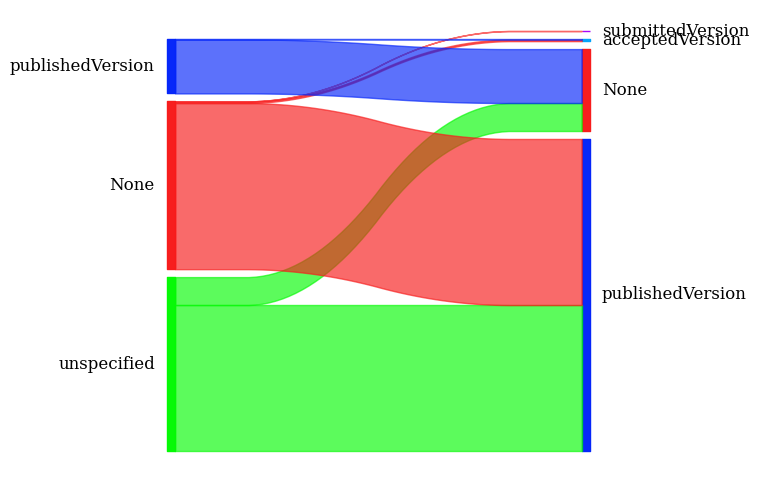

In [501]:
# sankey map of version change
# references here: https://github.com/SZJShuffle/pySankey2/blob/master/example/pySankey2_demo.ipynb
# sankey diagram with pySankey
from pySankey.sankey import sankey
colors = {
    'None':'#f71b1b',
    'publishedVersion':'#f58c0c',
    'unspecified':'#04f904',
    'acceptedVersion':'#04a3f9',
    'nan':'#848484',
    'publishedVersion':'#0425f9',
    'submittedVersion':'#a704f9'
}

sankey(left=false_match_on_license_version_df['license_version'],
        right=false_match_on_license_version_df['oa_version'],
        aspect=20,
        colorDict=colors,
        fontsize=12)

### languages
- [x] change between Crossref and OpenAlex
- [ ] count of types
- [ ] % declared in abstract
    - found in XML API
- [ ] % declared in journal title level
    - found in REST API
- [ ] visualization of distribution of language types

In [20]:
#language

# match on crossref_df[['DOI',type]] and openalex_df[['oa_doi','oa_type', 'oa_type_crossref']]
match_on_lang_df = crossref_df[['DOI','language']].merge(openalex_df[['oa_doi','oa_language']], left_on='DOI', right_on='oa_doi', how='inner')
match_on_lang_df.drop_duplicates(keep='first', inplace=True)
#convert NaN to 'None' for both columns
match_on_lang_df[['language','oa_language']] = match_on_lang_df[['language','oa_language']].fillna('None')
#do matching process
match_on_lang_df['match_on_lang'] = match_on_lang_df['language'] == match_on_lang_df['oa_language']

match_on_lang_df = match_on_lang_df.drop(['oa_doi'], axis=1)
match_on_lang_df_grouped = pd.DataFrame(match_on_lang_df.groupby(match_on_lang_df['match_on_lang'])['DOI'].count())
# add percent
match_on_lang_df_grouped['percent'] = match_on_lang_df_grouped['DOI'].apply(lambda x: f"{x/len(match_on_lang_df)*100:.2f}")
print(Fore.LIGHTCYAN_EX + f"Matched on Language: \n{match_on_lang_df_grouped}")

#match_on_lang_df_grouped.to_excel("Part_2_tables/match_on_lang_df_grouped.xlsx")
match_on_lang_df

Matched on Language: 
                DOI percent
match_on_lang              
False          5217   52.23
True           4771   47.77


,DOI,language,oa_language,match_on_lang
0,10.1521/soco.2021.39.5.543,en,en,True
1,10.1097/md.0000000000041851,en,en,True
2,10.32996/jmcie.2021.2.2.10,None,en,False
3,10.12957/cdf.2025.89476,None,pt,False
4,10.51845/36.4.15,None,en,False
...,...,...,...,...
9989,10.7591/cornell/9781501766985.003.0002,en,en,True
9990,10.1093/hesc/9780198866657.003.0038,en,en,True
9991,10.3735/9781935306627.book-part-182,None,en,False
9992,10.1093/oso/9780197619995.003.0005,en,en,True


In [21]:
# groupby 
false_match_on_lang = match_on_lang_df[match_on_lang_df['match_on_lang']==False]
print(f"Length of false langs: {len(false_match_on_lang)}")
false_match_on_lang_grouped = false_match_on_lang.groupby(['language','oa_language'])['DOI'].count()
print(Fore.LIGHTCYAN_EX + f"Matched on lang that are false and by Crossref language: \n{false_match_on_lang_grouped}")
print(Fore.LIGHTYELLOW_EX + f"Length of false_match_on_lang_grouped: {len(false_match_on_lang_grouped)}\n")
#false_match_on_lang_grouped.to_excel("Part_2_tables/false_match_on_lang_grouped.xlsx")
false_match_on_lang_grouped = pd.DataFrame(false_match_on_lang_grouped)
false_match_on_lang_grouped

Length of false langs: 5217
Matched on lang that are false and by Crossref language: 
language  oa_language
None      ar             41
          bg              2
          cs              1
          da              1
          de             42
                         ..
ru        en             17
sl        en              1
tr        en              1
uk        en             13
uz        en              1
Name: DOI, Length: 74, dtype: int64
Length of false_match_on_lang_grouped: 74



DOI
language oa_language     
None     ar            41
         bg             2
         cs             1
         da             1
         de            42
...                   ...
ru       en            17
sl       en             1
tr       en             1
uk       en            13
uz       en             1

[74 rows x 1 columns]

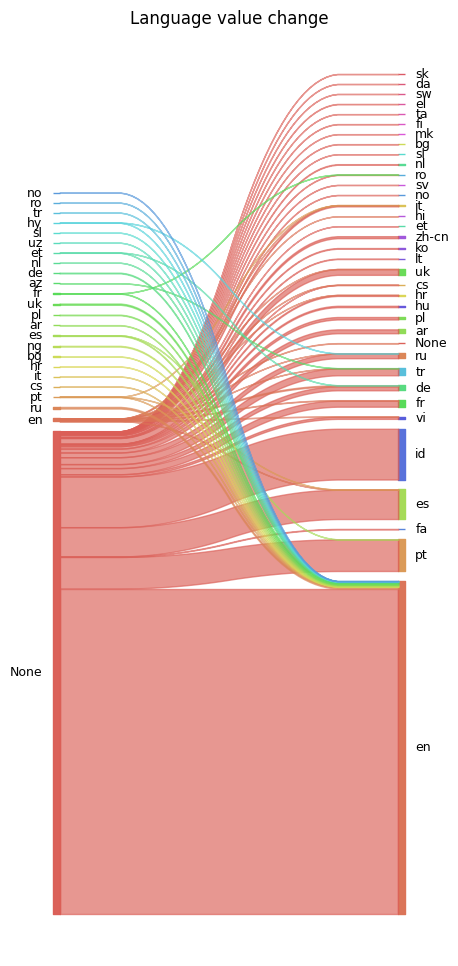

In [47]:
# sankey diagram with pySankey
from pySankey.sankey import sankey
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'TimesNewRoman'


sankey(left=false_match_on_lang['language'],
        right=false_match_on_lang['oa_language'],
        aspect=180,
        #colorDict=colors,
        fontsize=9,
        figure_name="Language value change",)

fig = plt.gcf()

# set size
fig.set_size_inches(8,8)

# set bg to white
fig.set_facecolor("w")

# set width height
fig.set_figheight(12)
fig.set_figwidth(5)

# set title
plt.title("Language value change")


# save the figure
fig.savefig("Part_2_data/plots/lang_sankey.png", bbox_inches="tight", dpi=150)

In [550]:
# what contains None in each df?
shared_corpus_df.drop_duplicates(keep='first', inplace=True)
shared_corpus_df.replace(np.nan,'None', inplace=True)
shared_corpus_df.columns
#url
none_cr_url_df = shared_corpus_df[shared_corpus_df['url']=='None']
print(Fore.LIGHTCYAN_EX + f"\nURL\n----\nCrossref URL == None: {len(none_cr_url_df)}, {len(none_cr_url_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_url_df = shared_corpus_df[shared_corpus_df['oa_primary_location_pdf_url']=='None']
print(Fore.LIGHTMAGENTA_EX + f"----\nOA PDF URL == None: {len(none_oa_url_df)}, {len(none_oa_url_df)/len(shared_corpus_df)*100:.2f}%")

#document type
none_cr_type_df = shared_corpus_df[shared_corpus_df['type']=='None']
print(Fore.LIGHTGREEN_EX + f"\nDOC TYPE\n----\nCrossref Type == None: {len(none_cr_type_df)}, {len(none_cr_type_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_type_df = shared_corpus_df[shared_corpus_df['oa_type']=='None']
print(Fore.LIGHTYELLOW_EX + f"----\nOA Doc Type == None: {len(none_oa_type_df)}, {len(none_oa_type_df)/len(shared_corpus_df)*100:.2f}%")

#title
none_title_df = shared_corpus_df[shared_corpus_df['oa_title']=='None']
print(Fore.LIGHTBLUE_EX + f"\nTITLE\n----\nOA Title == None: {len(none_title_df)}, {len(none_title_df)/len(shared_corpus_df)*100:.2f}%")

#abstract
none_cr_abstract_df = shared_corpus_df[shared_corpus_df['oa_abstract']=='<jats:p>None</jats:p>']
print(Fore.LIGHTCYAN_EX + f"\nABSTRACT\n----\nCrossref Abstract == None: {len(none_cr_abstract_df)}, {len(none_cr_abstract_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_abstract_df = shared_corpus_df[shared_corpus_df['oa_abstract']=='None']
print(Fore.LIGHTCYAN_EX + f"\nABSTRACT\n----\nOA Abstract == None: {len(none_oa_abstract_df)}, {len(none_oa_abstract_df)/len(shared_corpus_df)*100:.2f}%")

#license type
none_cr_license_type_df = shared_corpus_df[shared_corpus_df['license_type']=='None']
print(Fore.LIGHTMAGENTA_EX + f"\nLICENSE\n----\nCrossref license == None: {len(none_cr_license_type_df)}, {len(none_cr_license_type_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_license_type_df = shared_corpus_df[shared_corpus_df['oa_license']=='None']
print(Fore.LIGHTCYAN_EX + f"----\nOA license == None: {len(none_oa_license_type_df)}, {len(none_oa_license_type_df)/len(shared_corpus_df)*100:.2f}%")

#license version
none_cr_license_ver_df = shared_corpus_df[shared_corpus_df['license_version']=='None']
print(Fore.LIGHTGREEN_EX + f"\nLICENSE VER\n----\nCrossref license version == None: {len(none_cr_license_ver_df)}, {len(none_cr_license_ver_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_license_ver_df = shared_corpus_df[shared_corpus_df['oa_version']=='None']
print(Fore.LIGHTYELLOW_EX + f"----\nOA license version == None: {len(none_oa_license_ver_df)}, {len(none_oa_license_ver_df)/len(shared_corpus_df)*100:.2f}%")

#language
none_cr_lang_df = shared_corpus_df[shared_corpus_df['language']=='None']
print(Fore.LIGHTCYAN_EX + f"\nLANGUAGE\n----\nCrossref language version == None: {len(none_cr_lang_df)}, {len(none_cr_lang_df)/len(shared_corpus_df)*100:.2f}%")

none_oa_lang_df = shared_corpus_df[shared_corpus_df['oa_language']=='None']
print(Fore.LIGHTMAGENTA_EX + f"----\nOA language version == None: {len(none_oa_lang_df)}, {len(none_oa_lang_df)/len(shared_corpus_df)*100:.2f}%")




URL
----
Crossref URL == None: 0, 0.00%
----
OA PDF URL == None: 4924, 49.30%

DOC TYPE
----
Crossref Type == None: 0, 0.00%
----
OA Doc Type == None: 0, 0.00%

TITLE
----
OA Title == None: 3, 0.03%

ABSTRACT
----
Crossref Abstract == None: 0, 0.00%

ABSTRACT
----
OA Abstract == None: 2, 0.02%

LICENSE
----
Crossref license == None: 4136, 41.41%
----
OA license == None: 5551, 55.58%

LICENSE VER
----
Crossref license version == None: 4136, 41.41%
----
OA license version == None: 3019, 30.23%

LANGUAGE
----
Crossref language version == None: 5118, 51.24%
----
OA language version == None: 23, 0.23%


# Subset analysis for false matching 
for title and abstract

### Title and abstract subset - those that failed to match
- [x] filter df from above for those with differences 
- [x] manual checking each title and abstract
- [ ] compare title from each source based on Levenshtein
- [ ] token counts, numeral, etc.
- [ ] apply classification
- [ ] identify which error types occur: incorrect values, missing info, inconsistent values
<br>
### token characteristics
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

In [505]:
# false_match_on_title
# use Levenshtein token-based distance, instead of character
import numpy as np
from Levenshtein import distance as lev_distance, seqratio as lev_seqratio
#for stopword removal option
import nltk
import os
from nltk.corpus import stopwords

NLTK_DATA = "/Users/poppyriddle/nltk_data" # this is a default lookup path

stopWords = set(stopwords.words('english'))

def remove_stopwords(x:str)->list:
    """
    for a given string, returns a list with no stopwords
    to do:
        include language version
    """
    words:list = x.split(" ")
    wordsFiltered:list = [w for w in words if w not in stopWords]
    return wordsFiltered

def token_based_levenshtein(text1:str, text2:str, stopwords_arg=None)->float:
    """takes as input, two multi-token strings
    Output: float as normalized distance between the two
    """

    # remove stopwords option
    if stopwords_arg == True:
        tokens1 = remove_stopwords(text1)
        #print(f"tokens1: {tokens1}")
        tokens2 = remove_stopwords(text2)
        #print(f"\n----\ntokens2: {tokens2}\n")
    else:
        #tokenize - no cleaning at this point
        tokens1 = text1.split()
        tokens2 = text2.split()

    #compute levenshtein distance
    #distance = lev_seqratio(tokens1,tokens2)
    distance = lev_distance(tokens1,tokens2)

    #normalize by distance to the max length of token seq
    max_length = max(len(tokens1), len(tokens2))
    normalized_distance = distance / max_length if max_length > 0 else 0

    return normalized_distance

text1 = false_match_on_title.iloc[0,1]
text2 = false_match_on_title.iloc[0,2]
print(Fore.GREEN + f"normalized between text1[0] and tex2[0]:\n {token_based_levenshtein(text1,text2,True):.3f}")
# note this applies to calling rows, not x like usual .apply
false_match_on_title['levenshtein'] = false_match_on_title.progress_apply(
    lambda row: token_based_levenshtein(row['title'], row['oa_title'], True), axis=1
    )

# save out to manually review and correct
# DO NOT UNCOMMENT UNLESS YOU WANT TO REASSESS THE DATA MANUALLY!
#false_match_on_title.to_excel('Part_2_data/false_match_on_title_2.xlsx')#CHANGED THE NAME AS A CHECK

# tried seqratio - this didn't really work either
#false_match_on_title.to_excel('Part_2_data/false_match_on_title_seqratio.xlsx',index=False)


normalized between text1[0] and tex2[0]:
 0.917


100%|██████████| 213/213 [00:00<00:00, 128804.32it/s]
<positron-console-cell-505>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


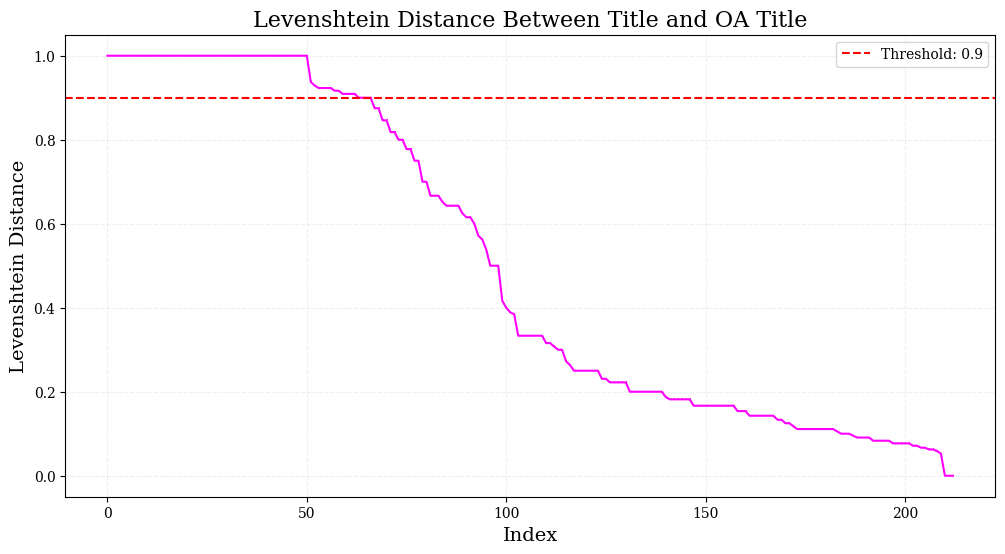

In [506]:
#visualize with simple matplotlib
import matplotlib.pyplot as plt

#sort by 'levenshtein'
false_match_on_title_sorted = false_match_on_title.sort_values(by='levenshtein',ascending=False)
false_match_on_title_sorted = false_match_on_title_sorted.reset_index()

#create line graph
plt.figure(figsize=(12, 6))
plt.plot(false_match_on_title_sorted['levenshtein'], marker=',', linestyle='-', color='magenta')

#horizontal line at a specified threshold
threshold = 0.9  #threshold value here
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')


#titles and labels
plt.title('Levenshtein Distance Between Title and OA Title', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Levenshtein Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.2)
#add legend
plt.legend()
#show the plot
plt.show()


# Manual review of false title
the false_match_on_title Excel spreadsheet was manually reviewed to see if a threshold could be inferred from the false positives. After manual review, the Levenshtein method is not sufficient to correctly identify. <br>
A manual review of each false title was performed. Two major categories were identified that created differences between the Crossref and OpenAlex title:
1) All caps, MathML markup, or HTML encodings 
2) translation differences
3) inclusion of subtitles - these were generally only found in the OpenAlex<br>
After manual review, the Excel spreadsheet was imported back here and combined with 'match_on_title_df' to get an improved count of TRUE/FALSE.

In [507]:
# import Part_2_data/false_match_on_title.xlsx after manual review
false_match_on_title_corrected = pd.read_excel("Part_2_data/false_match_on_title.xlsx")
false_match_on_title_corrected.drop_duplicates(keep='first', inplace=True)
#false_match_on_title_corrected = false_match_on_title_corrected.drop(columns=['Unnamed: 0'])
false_match_on_title_corrected
# combine_first() with original false_match_on_title to correct values in match on title
false_match_on_title_corrected = false_match_on_title_corrected.set_index('DOI')
match_on_title_df_set = match_on_title_df.set_index('DOI')
match_on_title_corrected = false_match_on_title_corrected.combine_first(match_on_title_df_set)
match_on_title_corrected = match_on_title_corrected.reset_index()

match_on_title_corrected = match_on_title_corrected.drop(columns=['levenshtein'])

match_on_title_corrected_grouped = pd.DataFrame(match_on_title_corrected.groupby(['match_on_title'])['DOI'].count())
match_on_title_corrected_grouped['percentage'] = match_on_title_corrected_grouped['DOI'].apply(lambda x: f"{x/len(match_on_title_df)*100:.2f}")

#save out
match_on_title_corrected_grouped.to_excel("Part_2_tables/match_on_title_corrected_grouped.xlsx")
print(Fore.LIGHTGREEN_EX + f" Match on title with corrections:\n{match_on_title_corrected_grouped}")


 Match on title with corrections:
                 DOI percentage
match_on_title                 
False            170       1.70
True            9928      99.40


# Manual review of false abstracts
Given the unconvincing results from Levenshtein, the dataset was reviewed manually to look for other characteristics that might create a pattern. Other than prefixes, the only pattern was the consistent difference in four groups: <br>
1) those that used structural terms, such as 'Background', 'Introduction', 'Objectives', 'Purpose' or combinations of these, and 
2) those that were different in language. <br>
3) a third minor group are those that were truncated in the OpenAlex column<br>
after manual review the dataset was imported and recombined with the original abstract dataframe to groupby and look at counts again.
4) omissions of abstracts in the OpenAlex column<br>

In third and last case, it is unknown how this occurs if the metadata was already present in the Crossref column. <br>

After manual review, it was combined with match_on_abstract_df to get an improved count of TRUE/FALSE matching.

In [508]:
#  import false_match_on_abstract.xlsx after manual review and add to match_on_abstract_df to get a better count
# presence of 'Abstract' 'Background' 'Introdcution' 'Objectives' or combinations with upper case 


# new match_on_title_count
false_match_on_abstract_corrected = pd.read_excel("Part_2_data/false_match_on_abstract.xlsx")
false_match_on_abstract_corrected.drop_duplicates(keep='first', inplace=True)

# combine_first() with original false_match_on_title to correct values in match on title
false_match_on_abstract_corrected = false_match_on_abstract_corrected.set_index('DOI')
match_on_abstract_df_set = match_on_abstract_df.set_index('DOI')
match_on_abstract_corrected = false_match_on_abstract_corrected.combine_first(match_on_abstract_df_set)
match_on_abstract_corrected = match_on_abstract_corrected.reset_index()

match_on_abstract_corrected_grouped = pd.DataFrame(match_on_abstract_corrected.groupby(['match_on_abstract'])['DOI'].count())
match_on_abstract_corrected_grouped['percentage'] = match_on_abstract_corrected_grouped['DOI'].apply(lambda x: f"{x/len(match_on_abstract_df)*100:.2f}")

#save out
match_on_abstract_corrected_grouped.to_excel("Part_2_tables/match_on_abstract_corrected_grouped.xlsx")
print(Fore.LIGHTYELLOW_EX + f" Match on abstract with corrections:\n{match_on_abstract_corrected_grouped}")



 Match on abstract with corrections:
                    DOI percentage
match_on_abstract                 
False               193       1.93
True               9905      99.17


# Apply pattern of characteristics from Part 1 to the shared_corpus_df in Part 2
- [ ] apply pattern
- [ ] analyze results
- [ ] visualise this?

## Problems to pattern with string or regex:

includes multiple languages, hiragana, General Punc, Dingbats, etc.	28 --> check unicode block for character set
1. MathML	9 --> check for inclusion of MathML tags
2. includes hyperlinks	6 --> check for http:// or https:// with regex or string method
3. includes figure	6 --> check for string pattern "Figure" or "Fig"
4. includes HTML	4 --> check for string pattern with HTML tags
5. article title used as abstract	4 --> check if abstract = title string method
6. first element is empty, but others have abstract	3 --> XML API call - count elements, if over 1, check if any are empty
7. includes tex-math, not MathML	1 --> check for string pattern for tex-math tags
8. includes table	2 --> check for string pattern for table follwed by a number
9. includes copyright statement	1 --> check for string pattern copyright or c with the circle char
10. test doi	1 --> check DOI against list of known test DOIs

## purpose
The goal is to take problems identified in the subset and then look for those in a larger sample, developing code that can be used to check future samples. 

In [551]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # see usage below; default='warn'

"""
Usage: 
with pd.option_context('mode.chained_assignment', None):#this suppresses warnings typical with use in Pandas
    # place code here
"""

# import data
abstract_subset_complete = pd.read_excel("data/part_1_df_abstract_subset.xlsx")

In [552]:
def check_for_math_ml(abstract:str)->bool:
    math_pattern = r"(<mml:.*>)"
    if re.search(math_pattern, abstract):
        a=True
    else:
        a=False
    return a

def check_for_tex_math(abstract:str)->bool:
    pattern = r"(<jats:tex-math>)"
    if re.search(pattern, abstract):
        a=True
    else:
        a=False
    return a

# (http.*)|(?:!<mml:.*>)
def check_for_http(abstract:str)->bool:
    pattern = [r"(https://.*)", r"(http://.*)"]
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    else:
        a = False
    return a

def check_for_HTML(abstract:str)->bool:
    pattern = [r"(&lt)", r"(&gt)", r"(div class=.*)"] 
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    elif re.search(pattern[2], abstract):
        a = True
    else:
        a = False
    return a

def check_for_figure(abstract:str)->bool:
    pattern = [r"Figure \d*", r"Fig. \d*"]
    if re.search(pattern[0], abstract):
        a = True
    elif re.search(pattern[1], abstract):
        a = True
    else:
        a = False
    return a

def check_for_table(abstract:str)->bool:
    pattern = [r"Table \d*"]
    if re.search(pattern[0], abstract):
        a = True
    else:
        a = False
    return a

def check_for_copyright(abstract:str)->bool:
    pattern = [r"(copyright-.*)", r"(<jats:copyright.*>)"]
    if re.search(pattern[0], abstract) or re.search(pattern[1], abstract):
        a = True
    else:
        a = False
    return a



In [554]:
shared_corpus_df.columns

Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type', 'oa_doi', 'oa_type',
       'oa_type_crossref', 'oa_is_paratext', 'oa_title', 'oa_abstract', 'oa_language', 'oa_cited_by_count',
       'oa_primary_location_pdf_url', 'oa_version', 'oa_license', 'oa_id'],
      dtype='object')

In [555]:

# of whole 9,988 sample from shared_corpus_df
fullset_check = shared_corpus_df[['DOI', 'oa_abstract']]
#apply function to new column
fullset_check['mathml_flag'] = fullset_check['oa_abstract'].map(check_for_math_ml)
abstract_sum = fullset_check['DOI'].count()
print(Fore.CYAN + f"\nCount of fullset: {abstract_sum}")
#percentage of MathML counts of abstract_subset_complete
fullset_mml_counts = fullset_check.groupby(['mathml_flag'])['DOI'].count()/abstract_sum*100
fullset_mml_counts.to_excel("tables/mml_counts_full_set.xlsx")

print(Fore.MAGENTA + f"\nMathML Counts as percentage of the full sample set\n------\n{fullset_mml_counts}\n")

# and check full set for tex-math
fullset_check['texmath_flag'] = fullset_check['oa_abstract'].map(check_for_tex_math)
# percentage of those from full set with tex-math tags
abstract_sum = fullset_check['DOI'].count()
fullset_texmath_counts = pd.DataFrame(fullset_check.groupby(['texmath_flag'])['DOI'].count()/abstract_sum*100)
fullset_texmath_counts.to_excel("tables/texmath_counts_fullset.xlsx")
print(Fore.LIGHTGREEN_EX + f"\n-------\nPercentage of full set with tex-math tags: \n{fullset_texmath_counts}")

# check for https or http on fullset
#apply function to new column
fullset_check['https_flag'] = fullset_check['oa_abstract'].map(check_for_http)
abstract_sum = fullset_check['DOI'].count()
#percentage of https or http counts of fullset
fullset_https_counts = pd.DataFrame(fullset_check.groupby(['https_flag'])['DOI'].count()/abstract_sum*100)
fullset_https_counts.to_excel("tables/https_counts_fullset.xlsx")

print(Fore.LIGHTBLUE_EX + f"\n------\nHttp counts as percentage of fullset, inclusive of MathML declarations: \n------\n{fullset_https_counts}\n")

# check for HMTL tags in abstract subset using check_for_HTML()
fullset_check['HTML_flag'] = fullset_check['oa_abstract'].map(check_for_HTML)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
fullset_HTML_counts = pd.DataFrame(fullset_check.groupby(['HTML_flag'])['DOI'].count()/abstract_sum*100)
fullset_HTML_counts.to_excel("tables/HTML_counts_fullset.xlsx")

print(Fore.LIGHTMAGENTA_EX + f"\n------\nHTML tag counts as percentage of fullset: \n------\n{fullset_HTML_counts}\n")

# check for Figure or Fig followed by digit in fullset using check_for_figure()
fullset_check['figure_flag'] = fullset_check['oa_abstract'].map(check_for_figure)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
fullset_figure_counts = pd.DataFrame(fullset_check.groupby('figure_flag')['DOI'].count()/abstract_sum*100)
fullset_figure_counts.to_excel("tables/figure_counts_fullset.xlsx")

print(Fore.LIGHTGREEN_EX + f"\n------\nFigure or Fig followed by digit counts as percentage of fullset: \n------\n{fullset_figure_counts}\n")

# check for Table followed by a digit in the fullset
fullset_check['table_flag'] = fullset_check['oa_abstract'].map(check_for_table)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
fullset_table_counts = pd.DataFrame(fullset_check.groupby('table_flag')['DOI'].count()/abstract_sum*100)
fullset_table_counts.to_excel("tables/table_counts_fullset.xlsx")

print(Fore.LIGHTRED_EX + f"\n------\nTablefollowed by digit counts as percentage of fullset: \n------\n{fullset_table_counts}\n")

# check for copyright term or tags in the fullset
fullset_check['copyright_flag'] = fullset_check['oa_abstract'].map(check_for_copyright)
abstract_sum = fullset_check['DOI'].count()
#percentage of HTML tag counts of fullset
fullset_copyright_counts = pd.DataFrame(fullset_check.groupby('copyright_flag')['DOI'].count()/abstract_sum*100)
fullset_copyright_counts.to_excel("tables/copyright_counts_fullset.xlsx")

print(Fore.LIGHTCYAN_EX + f"\n------\nCopyright counts as percentage of fullset: \n------\n{fullset_copyright_counts}\n")


Count of fullset: 9988

MathML Counts as percentage of the full sample set
------
mathml_flag
False    99.769724
True      0.230276
Name: DOI, dtype: float64


-------
Percentage of full set with tex-math tags: 
                DOI
texmath_flag       
False         100.0

------
Http counts as percentage of fullset, inclusive of MathML declarations: 
------
                  DOI
https_flag           
False       98.878654
True         1.121346


------
HTML tag counts as percentage of fullset: 
------
                 DOI
HTML_flag           
False      93.892671
True        6.107329


------
Figure or Fig followed by digit counts as percentage of fullset: 
------
                   DOI
figure_flag           
False        99.739688
True          0.260312


------
Tablefollowed by digit counts as percentage of fullset: 
------
                  DOI
table_flag           
False       99.889868
True         0.110132


------
Copyright counts as percentage of fullset: 
------
             

In [557]:
#combine all the fullsets into one
fullset_all_dfs = pd.concat([fullset_mml_counts,
                    fullset_texmath_counts,
                    fullset_https_counts,
                    fullset_HTML_counts,
                    fullset_figure_counts,
                    fullset_table_counts,
                    fullset_copyright_counts],
                    axis=1,
                    keys=['mml_counts', 'texmath_counts', 'https_counts', 'HTML_counts','figure_counts','table_counts','copyright_counts'])

fullset_all_dfs.to_excel("Part_2_tables/OpenAlex_fullset_all_dfs_table.xlsx")
fullset_all_dfs = fullset_all_dfs.replace(np.nan, 0)
fullset_all_dfs

,mml_counts,texmath_counts,https_counts,HTML_counts,figure_counts,table_counts,copyright_counts
,DOI,DOI,DOI,DOI,DOI,DOI,DOI
False,99.769724,100.0,98.878654,93.892671,99.739688,99.889868,99.989988
True,0.230276,0.0,1.121346,6.107329,0.260312,0.110132,0.010012


# diagram of crosswalk between Crossref and OpenAlex

- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
    - [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc

In [ ]:
#parse json data into each element:
data = data #returned from OpenAlex REST API
oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
oa_title = data['results'][0]['title']
oa_id = data['results'][0]['id']
oa_type = data['results'][0]['type']
oa_type_crossref = data['results'][0]['type_crossref']
oa_language = data['results'][0]['language']
oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
oa_cited_by_count = data['results'][0]['cited_by_count']
oa_is_paratext = data['results'][0]['is_paratext']
oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
oa_license = data['results'][0]['primary_location']['license']
oa_version = data['results'][0]['primary_location']['version']